In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import transformers as tf
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to('cuda')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# def process_data(data):

#     conditions = [
#         (data['label'] == 'NOT'),
#         (data['label'] == 'ABU'),
#     ]

#     choices = [0, 1]
#     data['label'] = np.select(conditions, choices, default=data['label'])

#     processed_data = data[['comment', 'label']]

#     return processed_data



In [ ]:
file_train = pd.read_csv("/content/drive/MyDrive/dataset/ALYT_train_bert.csv")

X = list(file_train["comment"])
y = list(file_train["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="macro")
    precision = precision_score(y_true=labels, y_pred=pred, average="macro")
    f1 = f1_score(y_true=labels, y_pred=pred, average="macro")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output_alyt",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    learning_rate=1e-5
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.325900
1000,0.295100


TrainOutput(global_step=1358, training_loss=0.3012947397133739, metrics={'train_runtime': 1063.9833, 'train_samples_per_second': 10.207, 'train_steps_per_second': 1.276, 'total_flos': 2857386061209600.0, 'train_loss': 0.3012947397133739, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.28455880284309387,
 'eval_accuracy': 0.9049723756906077,
 'eval_precision': 0.7834300386821396,
 'eval_recall': 0.7007107941530687,
 'eval_f1': 0.7320789270764485,
 'eval_runtime': 96.6129,
 'eval_samples_per_second': 28.102,
 'eval_steps_per_second': 3.519,
 'epoch': 1.0}

In [ ]:
trainer.save_model('output_alyt/alyt_bert_model')

In [ ]:
model = BertForSequenceClassification.from_pretrained('output_alyt/alyt_bert_model')
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
def predict_comment(comment, model):
    input = tokenizer(comment,padding = True, truncation = True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        output = model(**input)
        predicted_class = torch.argmax(output.logits, dim=1).item()
    return predicted_class

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5137
           1       0.66      0.46      0.54       682

    accuracy                           0.91      5819
   macro avg       0.80      0.71      0.75      5819
weighted avg       0.90      0.91      0.90      5819




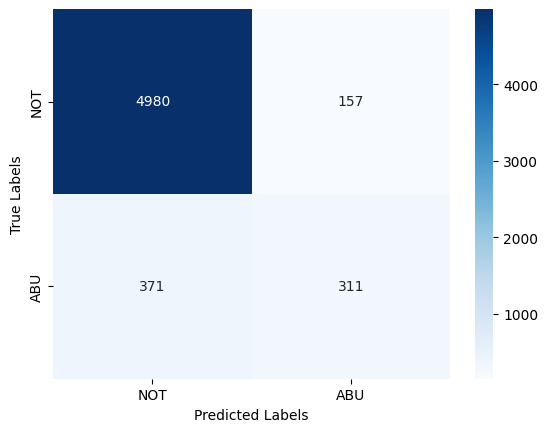

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5137
           1       0.66      0.46      0.54       682

    accuracy                           0.91      5819
   macro avg       0.80      0.71      0.75      5819
weighted avg       0.90      0.91      0.90      5819



In [ ]:
data_test = pd.read_csv("/content/drive/MyDrive/dataset/ALYT_test_bert.csv")
data_test['pred'] = data_test['comment'].apply(lambda x: predict_comment(x, model))
y_gold = data_test["label"]
y_pred = data_test["pred"]
report = classification_report(y_gold, y_pred, digits=2)
print(report)
print()
confusion_matrix_data = sklearn.metrics.confusion_matrix(y_gold, y_pred)
cm = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
classes = ['NOT', 'ABU']
cm.set_xticklabels(classes)
cm.set_yticklabels(classes)
plt.show()
data_test.to_csv('/content/drive/MyDrive/predictions/alyt/ALYT_def_bert.csv', index=False)
print(report)

Predictions on Obfuscated dataset

In [ ]:
def predict_comment(comment, model):
    input = tokenizer(comment,padding = True, truncation = True, return_tensors='pt').to('cuda')
    with torch.no_grad():
        output = model(**input)
        predicted_class = torch.argmax(output.logits, dim=1).item()
    return predicted_class

def predict(file_path, model):
    df = pd.read_csv(file_path)
    df['pred'] = df['obfuscated_comment'].apply(lambda x: predict_comment(x, model))
    return df

def generate_classification_report(df):
    y_gold = df["label"]
    y_pred = df["pred"]
    report = classification_report(y_gold, y_pred, digits=2)
    confusion_matrix_data = sklearn.metrics.confusion_matrix(y_gold, y_pred)
    cm = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    classes = ['NOT', 'ABU']
    cm.set_xticklabels(classes)
    cm.set_yticklabels(classes)
    plt.show()
    return report

    return report

def evaluate(data_path, model, save=True):
    df_pred = predict(data_path, model)
    if save:
        output_file = f'{os.path.basename(data_path).split(".")[0]}_pred.csv'
        output_path = f'/content/drive/MyDrive/predictions/alyt/{output_file}'
        df_pred.to_csv(output_path, index=False)
    print(generate_classification_report(df_pred))

Classification report for ALYT_OBF_bert_1interleave.csv


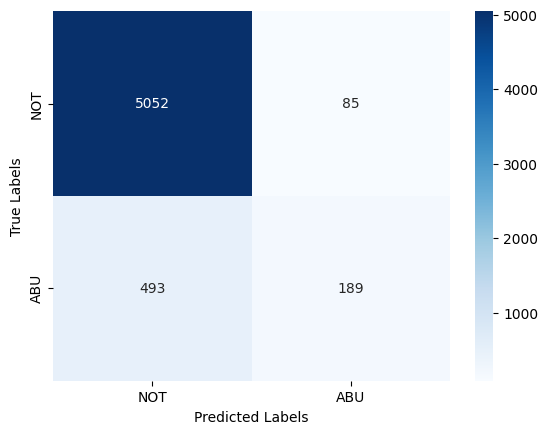

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5137
           1       0.69      0.28      0.40       682

    accuracy                           0.90      5819
   macro avg       0.80      0.63      0.67      5819
weighted avg       0.89      0.90      0.88      5819


Classification report for ALYT_OBF_bert_2swapchar.csv


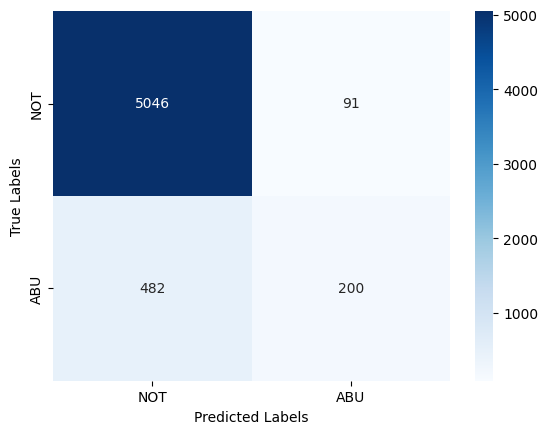

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5137
           1       0.69      0.29      0.41       682

    accuracy                           0.90      5819
   macro avg       0.80      0.64      0.68      5819
weighted avg       0.89      0.90      0.88      5819


Classification report for ALYT_OBF_bert_3replace_o.csv


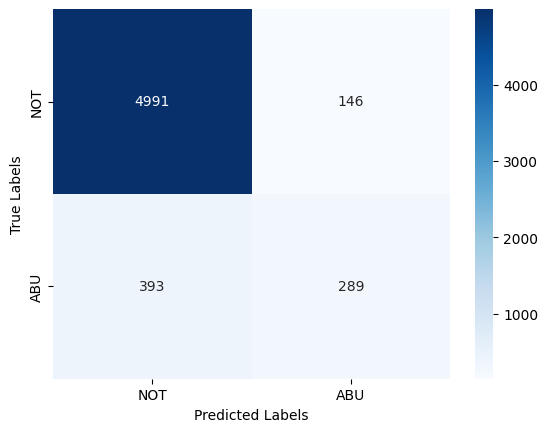

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5137
           1       0.66      0.42      0.52       682

    accuracy                           0.91      5819
   macro avg       0.80      0.70      0.73      5819
weighted avg       0.90      0.91      0.90      5819


Classification report for ALYT_OBF_bert_4ommit_char.csv


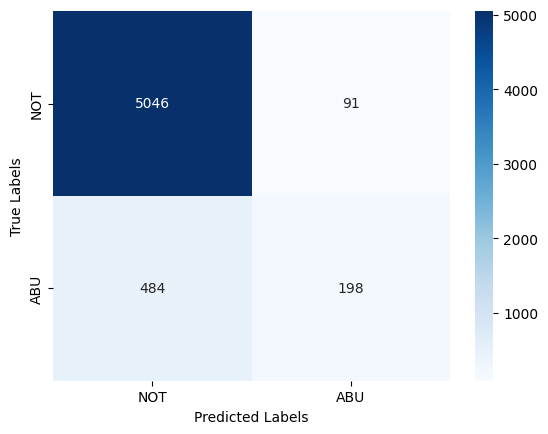

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5137
           1       0.69      0.29      0.41       682

    accuracy                           0.90      5819
   macro avg       0.80      0.64      0.68      5819
weighted avg       0.89      0.90      0.88      5819


Classification report for ALYT_OBF_bert_5extra_char.csv


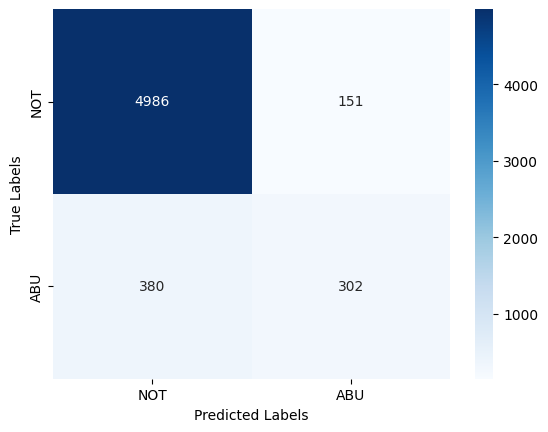

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5137
           1       0.67      0.44      0.53       682

    accuracy                           0.91      5819
   macro avg       0.80      0.71      0.74      5819
weighted avg       0.90      0.91      0.90      5819


Classification report for ALYT_OBF_bert_6to_asterisks.csv


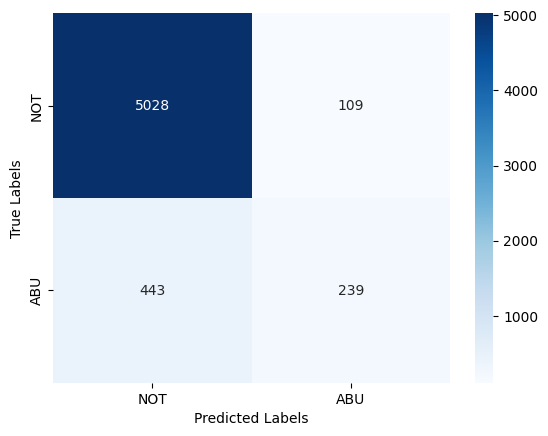

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5137
           1       0.69      0.35      0.46       682

    accuracy                           0.91      5819
   macro avg       0.80      0.66      0.71      5819
weighted avg       0.89      0.91      0.89      5819


Classification report for ALYT_OBF_bert_7duplicate_char.csv


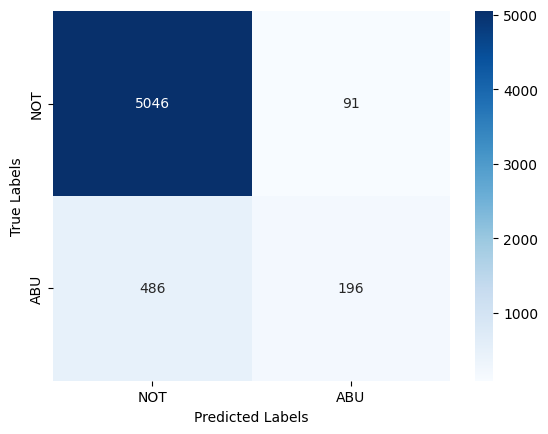

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5137
           1       0.68      0.29      0.40       682

    accuracy                           0.90      5819
   macro avg       0.80      0.63      0.68      5819
weighted avg       0.89      0.90      0.88      5819


Classification report for ALYT_OBF_bert_8random_obf.csv


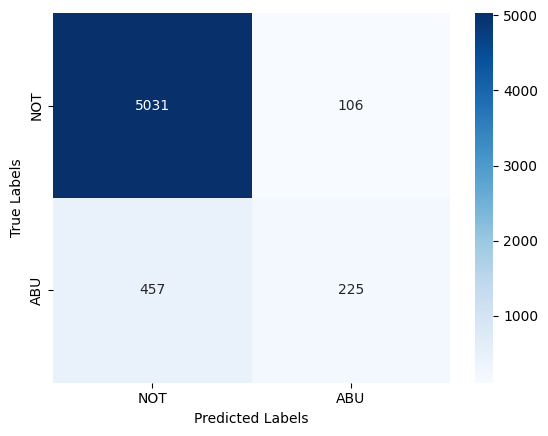

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      5137
           1       0.68      0.33      0.44       682

    accuracy                           0.90      5819
   macro avg       0.80      0.65      0.70      5819
weighted avg       0.89      0.90      0.89      5819




In [ ]:
path_data = '/content/drive/MyDrive/dataset/alyt_obf/'
for f in os.listdir(path_data):
    if f.endswith('.csv'):
        print(f"Classification report for {f}")
        evaluate(os.path.join(path_data, f), model)
        print()